<h1>
<center>Finding Submarines</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

The following code helps you visualize the submarine data and contains the crucial information about the data such as size of measurement domain, number of grid points and frequency modes etc. 

Our first task is to import the data into python (similarly MATLAB). Three files are available, "subdata.npy" is a numpy binary file most conveninet for Python users. "subtata.mat" is best if you plan to use MATLAB and "subdata.csv" is the same data in text format if you are having trouble with the other formats. In MATLAB you can simply use the load command. In Python, and in particular if you are using something like Colab you need some utilities to load the data. Here's a small snippet for loading data from your Google drive.   

In [ ]:
from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

data_path = '/content/drive/My Drive/subdata.npy'

d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)

ValueError: ignored

In [ ]:
# import libraries for plotting isosurfaces
import plotly
import plotly.graph_objs as go
# utility for clearing output of cell as loop runs in notebook
from IPython.display import clear_output

# plot the data in time 

L = 10; # length of spatial domain (cube of side L = 2*10)
N_grid = 64; # number of grid points/Fourier modes in each direction
xx = np.linspace(-L, L, N_grid+1) #spatial grid in x dir
x = xx[0:N_grid]
y = x # same grid in y,z direction
z = x
xv, yv, zv = np.meshgrid(x, y, z) # generate 3D meshgrid for plotting

K_grid = (2*np.pi/(2*L))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid) # frequency grid for one coordinate
kx, ky, kz = np.meshgrid(K_grid, K_grid, K_grid)

# plot iso surfaces for every third measurement
# for j in range(0,49,3):
#   signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid))
#   normal_sig_abs = np.abs(signal)/np.abs(signal).max()

#   # generate data for isosurface of the 3D data 
#   fig_data = go.Isosurface( x = xv.flatten(), y = yv.flatten(), z = zv.flatten(),
#                            value = normal_sig_abs.flatten(), isomin=0.7, isomax=0.7)

#   # generate plots
#   clear_output(wait=True) # need this to discard previous figs
#   fig = go.Figure( data = fig_data )
#   fig.show()


In [ ]:
# TASK 1: Averaging of the FT and visual inspection to determine 
# the frequency signature (center freq) generated by submarine. 
sum = 0.0
for col in range(d.shape[1]): # columns 0-48
  d_reshape = np.reshape(d[:,col], (N_grid, N_grid, N_grid)) # frequency  
  d_reshape_fft = np.fft.fftshift(np.fft.fftn(d_reshape)) 
  sum = sum + d_reshape_fft

avg = np.abs(sum / d.shape[1]) # len(d.columns) is number of cols, 49
max = np.max(avg)
max_indexes = np.unravel_index(np.argmax(avg), avg.shape)
cfx, cfy, cfz = kx[max_indexes], ky[max_indexes], kz[max_indexes]
print(cfx, cfy, cfz)
# Plot 3D
fig_data = go.Isosurface(x = kx.flatten(), y = ky.flatten(), z = kz.flatten(),
                         value = avg.flatten()/max, isomin = 0.7, isomax=0.7)
clear_output(wait=True)
fig = go.Figure(data=fig_data)
fig.update_layout(title_text='Central Frequency in the Frequency Domain', title_x=0.5, title_y=0.85)
fig.update_layout(scene=dict(xaxis_title='kx', yaxis_title='ky', zaxis_title='kz'))
fig.show()
# There are 2 main points around approximately (+- cfx, +- cfy, +- cfz)

In [ ]:
# TASK 2: Filter to extract the freq signature to denoise 
# the data and determine path of submarine.
# Plot the 3D path of submarine. 
import pandas as pd

# Gaussian filter (centered around (+- cfx, +- cfy, +- cfz))
sigma = 2.5
filter = np.exp(-(((kx-cfx)**2 + (ky-cfy)**2 + (kz-cfz)**2) / (2*sigma**2))) + np.exp(-(((kx+cfx)**2 + (ky+cfy)**2 + (kz+cfz)**2) / (2*sigma**2)))
filter_shift = np.fft.fftshift(filter)

# 3D Location 
location = pd.DataFrame(data=np.NaN, index=['x', 'y', 'z'], columns=range(0,49)) # 3x49 matrix
for col in range(d.shape[1]): # columns 0-48
  d_reshape = np.reshape(d[:,col], (N_grid, N_grid, N_grid))
  d_reshape_fft_filtered = filter_shift * np.fft.fftn(d_reshape)
  d_reshape_denoise = np.real(np.fft.ifftn(d_reshape_fft_filtered))

  max = np.max(d_reshape_denoise)
  max_indexes = np.unravel_index(np.argmax(d_reshape_denoise), d_reshape_denoise.shape)

  xloc = xv[max_indexes]
  yloc = yv[max_indexes]
  zloc = zv[max_indexes]

  location[col]['x'] = xloc
  location[col]['y'] = yloc
  location[col]['z'] = zloc

fig = go.Figure(data=[go.Scatter3d(x=location.loc['y'], y=location.loc['x'], z=location.loc['z'], marker=dict(size=2, colorscale='Viridis'))])
fig.update_layout(title_text='Submarine\'s 3D Path (24 hours)', title_x=0.5, title_y=0.85)
fig.show()

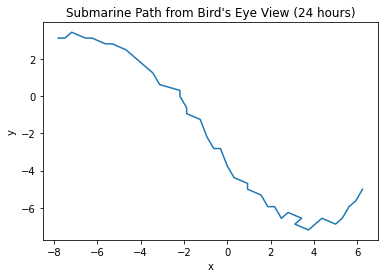

In [ ]:
# TASK 3: Determine and plot the x,y coordinates of the submarine during 24 hour period.
import matplotlib.pyplot as plt
plt.plot(location.loc['y'], location.loc['x'])
plt.title('Submarine Path from Bird\'s Eye View (24 hours)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
pd.set_option('display.max_columns', None)
location.to_csv('/content/drive/My Drive/location.csv')